In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.spatial.transform import Rotation as R
from diff_gaussian_rasterization import rasterize, rasterize_jit
import matplotlib.pyplot as plt

In [41]:
key = jax.random.PRNGKey(3)
def loss( means3D, colors_precomp, opacity, scales, rotations,
    image_width, image_height, fx,fy, cx,cy,near,far, color_gt):
    color = rasterize(
        means3D, colors_precomp, opacity, scales, rotations,
        image_width, image_height, fx,fy, cx,cy,near,far
    )
    return jnp.sum(0.5 * (color[:3] - color_gt[:3])**2)

loss_grad = jax.jit(jax.grad(loss, argnums=(0,1,2,3,4,)), static_argnums=(5,6,7,8,9,10,11,12,))

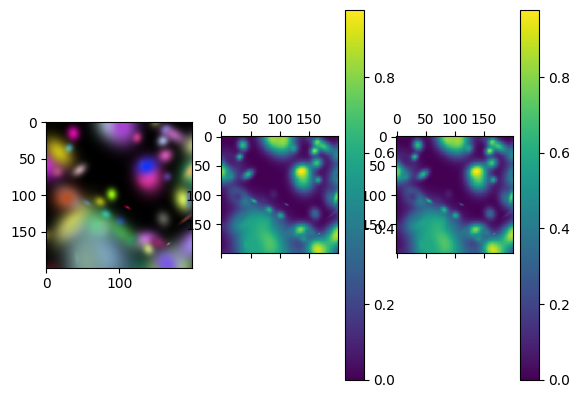

In [70]:
image_width, image_height, fx, fy, cx, cy, near, far = 200, 200, 300.0, 300.0, 100.0, 100.0, 0.01, 2.5

N = 100
key = jax.random.split(key, 2)[0]
means3D = jax.random.uniform(key, shape=(N, 3), minval=-0.5, maxval=0.5) + jnp.array([0.0, 0.0, 1.0])
N = means3D.shape[0]
key = jax.random.split(key, 1)[0]
colors_precomp = jax.random.uniform(key, shape=(N,3), minval=0.0, maxval=1.0)
opacity = jnp.ones(shape=(N,1))
scales =jnp.ones((N,3)) * 4.5400e-02
rotations = jax.random.uniform(key, shape=(N,4), minval=-1.0, maxval=1.0)

color_gt = rasterize_jit(
    means3D, colors_precomp, opacity, scales, rotations,
    image_width, image_height, fx,fy, cx,cy,near,far
)
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
ax1.imshow(jnp.transpose(color_gt[:3,...], (1,2,0)))
im = ax2.matshow(color_gt[3,...])
fig.colorbar(im, ax=ax2)
im = ax3.matshow(color_gt[4,...])
fig.colorbar(im, ax=ax3)

# fig.colorbar(im, cax=ax3, orientation='vertical')


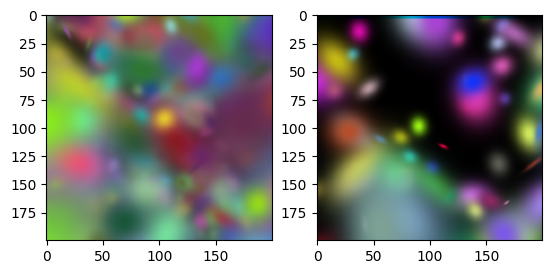

In [105]:
N = 500
key = jax.random.split(key, 1)[0]
means3D = jax.random.uniform(key, shape=(N, 3), minval=-0.5, maxval=0.5) + jnp.array([0.0, 0.0, 1.0])
N = means3D.shape[0]
key = jax.random.split(key, 1)[0]
colors_precomp = jax.random.uniform(key, shape=(N,3), minval=0.0, maxval=1.0)
opacity = jnp.ones(shape=(N,1))
scales =jnp.ones((N,3)) * 4.5400e-02
rotations = jax.random.uniform(key, shape=(N,4), minval=-1.0, maxval=1.0)

color = rasterize_jit(
    means3D, colors_precomp, opacity, scales, rotations,
    image_width, image_height, fx,fy, cx,cy,near,far
)

fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color[:3], (1,2,0)))
ax2.imshow(jnp.transpose(color_gt[:3], (1,2,0)))

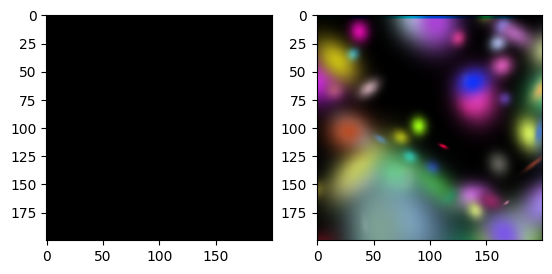

In [110]:
for _ in range(100):
    (
        dL_dmeans3D,
        dL_dcolors,
        dL_dopacity,
        dL_dscales,
        dL_drotations,
    ) = loss_grad(
        means3D, colors_precomp, opacity, scales, rotations,
        image_width, image_height, fx,fy, cx,cy,near,far, color_gt
    )

    color = rasterize_jit(
        means3D, colors_precomp, opacity, scales, rotations,
        image_width, image_height, fx,fy, cx,cy,near,far
    )

    colors_precomp = colors_precomp - dL_dcolors[:,:3]  * 0.0004
    means3D = means3D - dL_dmeans3D  * 0.00001
    scales = scales - dL_dscales  * 0.00001
    rotations = rotations - dL_drotations  * 0.00001
    # opacity = opacity - dL_dopacity  * 0.000001
fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color[:3], (1,2,0)))
ax2.imshow(jnp.transpose(color_gt[:3], (1,2,0)))

In [109]:
opacity.sum()

Array(0.00019831, dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


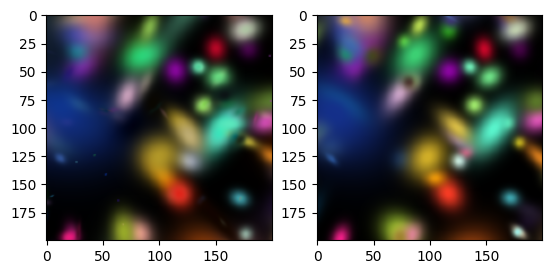